In [1]:
spark.conf.set("spark.sql.shuffle.partitions", 1000)
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

In [2]:
from pyspark.ml.clustering import KMeans, KMeansModel, BisectingKMeans, BisectingKMeansModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, PCA, PCAModel, ElementwiseProduct
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql.functions import col, sum, greatest, expr, count, countDistinct, max, min, variance, bround, avg, lit, udf
from pyspark.sql import Row
import pandas as pd
import scipy.stats as stats
import matplotlib.pylab as plt
from pyspark.ml.linalg import Vectors
from pyspark.ml.linalg import SparseVector, DenseVector

#PARA EL TRATAMIENTO DE OUTLIERS
from pyspark.sql.functions import col, count, when
from functools import reduce
from operator import and_

/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/opt/conda/lib/python3.5/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')



### Data Importation

In [3]:
dfEM=spark.read.parquet("/analytics/bc1_clustering/tables/dfEM")

In [4]:
#dfBufferOrig=spark.read.parquet("/analytics/bc1_clustering/tables/dfBufferAccYrGrpPart")
#dfBufferOrig=spark.read.parquet("/analytics/bc1_clustering/tables/dfBufferAccYrSubPart2")
# dfBufferOrig=spark.read.parquet("/analytics/bc1_clustering/tables/dfBufferAccYrGrp")
dfBufferOrig=spark.read.parquet("/analytics/bc1_clustering/tables/dfFinalMatrix11Dic")
# dfBufferOrig=dfBufferOrig.withColumnRenamed('','NULO')

In [5]:
# dfBufferOrig.persist()

nameList=dfBufferOrig.schema.names[1:]

len(nameList)

727

In [6]:
dfBufferOrig.count()

4166747

In [7]:
# [dfBuffer, dfTestBuffer] = dfBufferOrig.randomSplit([0.5, 0.5],666)

In [6]:
dfBuffer=dfBufferOrig.where(~dfBufferOrig['ACCOUNTPK'].cast('string').substr(-1,1).isin(['0','1','2','3','4'])).persist()

In [7]:
dfTestBuffer=dfBufferOrig.where(dfBufferOrig['ACCOUNTPK'].cast('string').substr(-1,1).isin(['0','1','2','3','4'])).persist()

In [10]:
#dfBuffer.write.parquet("/analytics/bc1_clustering/tables/dfTrainBufferBin")

In [11]:
#dfTestBuffer.write.parquet("/analytics/bc1_clustering/tables/dfTestBufferBin")

In [12]:
# dfBuffer=spark.read.parquet("/analytics/bc1_clustering/tables/dfTrainBufferBin")
# dfBuffer.persist()
# nameList=dfBuffer.schema.names[1:]

In [13]:
# dfTestBuffer=spark.read.parquet("/analytics/bc1_clustering/tables/dfTestBufferBin")
# dfTestBuffer.persist()

In [ ]:
dfBuffer.count()

2067865

In [ ]:
dfTestBuffer.count()

In [ ]:
#dfTestBuffer.select(variance(dfTestBuffer.columns[2])).show()

In [ ]:
#dfBufferOrig.select(dfBufferOrig['ACCOUNTPK'].cast('string').substr(-1,1).alias('caracter')).groupBy('caracter').count().show()

In [ ]:
# dfTsys=spark.read.parquet("/analytics/bc1_clustering/tables/dfTsysAccYrOriginal")

In [ ]:
# dfTsys.persist()

In [ ]:
dfTsys=dfBufferOrig.select('ACCOUNTPK','Emprestimo_Pessoal','Pagamento_de_Contas','Parcelamento_Fatura_Automatico','Parcelamento_Fatura_Facil','Saque_Parcelado','Saque_a_Vista','Overlimit')

### Binary matrix creation

In [21]:
dfBufferBinary=dfBufferOrig.select([ i if i=='ACCOUNTPK' else when(col(i)!=0,1).otherwise(0).alias(i) for i in dfBufferOrig.columns])

In [ ]:
dfBufferBinary.persist().count()

In [ ]:
dfBufferBinary.write.parquet("/analytics/bc1_clustering/tables/dfBufferAccYrSubPartBin2")

In [ ]:
# #TEST CONVERSOR A MATRIZ 0/1
# l = [('A',2.0,-3.0,0,-30.0),('B',0,-300.0,1,0),('C',7.0,0.0,2,-50.0),('D',12.0,-700.0,0,0)]
# rdd = sc.parallelize(l)
# dummy = rdd.map(lambda x: Row(ID=x[0], col1=float(x[1]),col2=float(x[2]),col3=float(x[3]),col4=float(x[4])))
# dummyDf = sqlContext.createDataFrame(dummy)
# dummyDf.show(5)
# dummyDf.select([ i if i=='ID' else when(col(i)!=0,1).otherwise(0).alias(i) for i in dummyDf.columns]).show()

### Variable distribution histogram

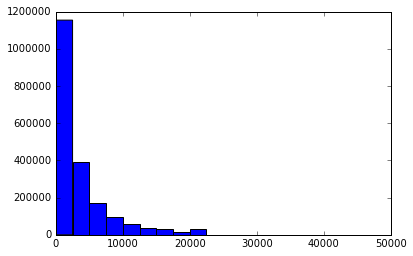

In [15]:
#METODO HISTOGRAM DF
plt.clf()
#bins, counts = dummyDf.select('col1').rdd.flatMap(lambda x: x).histogram(20)
bins, counts = dfBuffer.select('CREDITLIMIT').rdd.flatMap(lambda x: x).histogram(20)
plt.hist(bins[:-1], bins=bins, weights=counts)

plt.show()
#.filter(col('101054')>0)

In [ ]:
# #METODO hist DE PLT, parece que no funciona con grandes cantidades de datos
# plt.clf()
# #n, bins, patches = plt.hist(dummyDf.select('col4').collect(), 15, normed=1, facecolor='green', alpha=0.75)
# n, bins, patches = plt.hist(dfBuffer.select('1010540800').collect(), 15, normed=1, facecolor='green', alpha=0.75)
# plt.show()

### Outlier treatment (for money value matrices)

In [ ]:
len(nameList)

In [ ]:
listaCols=[]
listaLimit=[]

for i in nameList:
    cuenta=dfBuffer.filter(col(i)>0).count()
    if cuenta>0:
        listaCols.append(i)
        Q1, Q3 = dfBuffer.filter(col(i)>0).approxQuantile(col=i,probabilities=[0.25,0.75],relativeError=0.01)
        IQR=(Q3-Q1)
        top_limit=Q3+9*IQR
        listaLimit.append(top_limit)

In [ ]:
expr=reduce(and_, [col(c) < t for c, t in zip(listaCols, listaLimit)])

In [ ]:
dfBufferOutlier=dfBuffer.where(expr)

In [ ]:
dfBufferOutlier.persist().count()

In [ ]:
dfBufferOutlier.write.parquet("/analytics/bc1_clustering/tables/dfBufferOutlier")

In [ ]:
dfBufferOutlier=spark.read.parquet("/analytics/bc1_clustering/tables/dfBufferOutlier")

In [ ]:
dfBufferOutlier.count()

### Feature Assembler and Scaler

#### Binary matrices

In [12]:
dfBufferOutlier=dfBuffer
#dfBufferOutlier=dfTestBuffer.select(dfTestBuffer.columns[0:2400])

In [10]:
#continuous_feature_assembler= VectorAssembler(inputCols=dfTestBuffer.columns[0:2400], outputCol="features")
continuous_feature_assembler= VectorAssembler(inputCols=nameList, outputCol="features")

In [11]:
estimatorsKmeans = [continuous_feature_assembler]

featurePipeline = Pipeline(stages=estimatorsKmeans)

sparkFeaturePipelineModel = featurePipeline.fit(dfBufferOutlier)

In [10]:
dfBufferFeature=sparkFeaturePipelineModel.transform(dfBufferOutlier).persist()

In [11]:
dfBufferFeature.count()

1331762

#### Money value matrices

In [11]:
#SI NO SE EJECUTA EL PROCESO DE OUTLIERS
dfBufferOutlier=dfBuffer
#dfBufferOutlier=dfTestBuffer.select(dfTestBuffer.columns[0:2400])

In [12]:
nameList=dfBuffer.schema.names[1:]

In [13]:
continuous_feature_assembler= VectorAssembler(inputCols=nameList, outputCol="unscaled_continuous_features")

In [14]:
continuous_feature_scaler = StandardScaler(inputCol="unscaled_continuous_features", outputCol="scaled_features",\
                                           withStd=True, withMean=True)

In [15]:
estimatorsKmeans = [continuous_feature_assembler, continuous_feature_scaler]

featurePipeline = Pipeline(stages=estimatorsKmeans)

sparkFeaturePipelineModel = featurePipeline.fit(dfBufferOutlier)

In [16]:
dfBufferScaled=sparkFeaturePipelineModel.transform(dfBufferOutlier).persist()

In [17]:
dfBufferScaled.count()

2067865

In [18]:
dfBufferScaled.printSchema()

root
 |-- ACCOUNTPK: long (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- INSTALMENTBALANCEFOROVLMCHECK: double (nullable = true)
 |-- CREDITLIMIT: double (nullable = true)
 |-- LimitUse: double (nullable = true)
 |-- LimitOffUs: double (nullable = true)
 |-- LimitPersLoan: double (nullable = true)
 |-- LimitCashOut: double (nullable = true)
 |-- CLOSING_BALANCE: double (nullable = true)
 |-- INSTALLMENTSOFFERS: long (nullable = true)
 |-- Emprestimo_Pessoal: long (nullable = true)
 |-- Pagamento_de_Contas: long (nullable = true)
 |-- Parcelamento_Fatura_Automatico: long (nullable = true)
 |-- Parcelamento_Fatura_Facil: long (nullable = true)
 |-- Saque_Parcelado: long (nullable = true)
 |-- Saque_a_Vista: long (nullable = true)
 |-- Overlimit: long (nullable = true)
 |-- Overlimit_Auth: integer (nullable = true)
 |-- NULO: double (nullable = true)
 |-- 0742: double (nullable = true)
 |-- 0763: double (nullable = true)
 |-- 0780: double (nullable = true)
 |-- 1520: double

#### Increase of the imporance of the financial variables (money)

In [19]:
listaPesos=([1]*727)
#listaPesos[0:17]=[10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10,10]
VectorPesos=DenseVector(listaPesos)

In [20]:
transformer = ElementwiseProduct(scalingVec=VectorPesos,
                                 inputCol="scaled_features", outputCol="features")
# Batch transform the vectors to create new column:
dfBufferFeature=transformer.transform(dfBufferScaled)

In [34]:
dfBufferFeature.select('scaled_features','features').show(1,truncate=False)

+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

### Dimensionality reduction (WIP)

In [37]:
pca = PCA(k=120, inputCol="features", outputCol="pca_features")

In [38]:
pcamodel = pca.fit(dfBufferFeature)

In [39]:
variance=pcamodel.explainedVariance

In [40]:
variance

DenseVector([0.0448, 0.0177, 0.0059, 0.0051, 0.0045, 0.0041, 0.0033, 0.0033, 0.0031, 0.003, 0.0028, 0.0028, 0.0028, 0.0026, 0.0026, 0.0025, 0.0025, 0.0025, 0.0024, 0.0024, 0.0024, 0.0023, 0.0022, 0.0022, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.0021, 0.002, 0.002, 0.002, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0019, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0018, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0017, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0016, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015, 0.0015])

In [41]:
variance.sum()

0.29033780953685812

In [42]:
dfBufferFeaturePCA=pcamodel.transform(dfBufferFeature)

### K Evaluation

In [ ]:
listaErrores=[]

for k in range(2,51):
    #print(k)
    kmeans = KMeans().setK(k).setSeed(666)
    #kmeans = BisectingKMeans().setK(k).setSeed(666)
    model = kmeans.fit(dfBufferFeature)
    wssse = model.computeCost(dfBufferFeature)
    print("Within Set Sum of Squared Errors {} = ".format(k) + str(wssse))
    listaErrores.append((k,wssse))

In [ ]:
pdErrors=pd.DataFrame.from_records(listaErrores, columns=['clusters','wssse'])

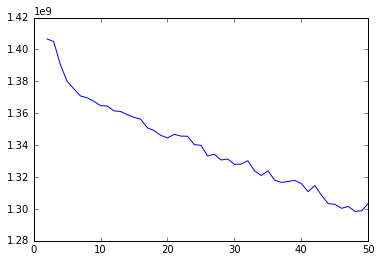

In [82]:
plt.clf()
plt.plot(pdErrors.clusters,pdErrors.wssse)
plt.show()

In [ ]:
dfErrors=spark.createDataFrame(pdErrors)

In [81]:
dfErrors.printSchema()

root
 |-- clusters: long (nullable = true)
 |-- wssse: double (nullable = true)



In [ ]:
# dfErrors.write.parquet("/analytics/bc1_clustering/tables/dfErrorsBin")

### Segmentation final model

In [21]:
#kmeans = KMeans().setK(16).setSeed(666)
kmeans = BisectingKMeans().setK(20).setMinDivisibleClusterSize(40000).setSeed(666)

In [22]:
dfBufferFeature.select("ACCOUNTPK","features").show(5)

+---------+--------------------+
|ACCOUNTPK|            features|
+---------+--------------------+
|    67805|[0.53276282052711...|
|   109366|[0.53276282052711...|
|   140126|[-3.5542295473636...|
|   142317|[-0.1740613477626...|
|   164347|[0.53276282052711...|
+---------+--------------------+
only showing top 5 rows



In [23]:
model = kmeans.fit(dfBufferFeature)

### Financial Product Inclination

#### Train

In [ ]:
dfTrainRes=model.transform(dfBufferFeature).select(col("ACCOUNTPK").alias("ACCOUNT"),"prediction")

In [ ]:
dfProdIncl=dfTrainRes.join(dfBuffer,dfTrainRes.ACCOUNT==dfTsys.ACCOUNTPK,'left_outer').fillna(0)

In [ ]:
dfProdIncl.printSchema()

In [ ]:
dfProdIncl.createOrReplaceTempView("tProdIncl")

In [ ]:
dfClusIncl=spark.sql("""SELECT prediction, 
    SUM(CASE WHEN Emprestimo_Pessoal>0 THEN 1 ELSE 0 END)/SUM(1) Emprestimo_Pessoal,
    SUM(CASE WHEN Pagamento_de_Contas>0 THEN 1 ELSE 0 END)/SUM(1) Pagamento_de_Contas, 
    SUM(CASE WHEN Parcelamento_Fatura_Automatico>0 THEN 1 ELSE 0 END)/SUM(1) Parcelamento_Fatura_Automatico, 
    SUM(CASE WHEN Parcelamento_Fatura_Facil>0 THEN 1 ELSE 0 END)/SUM(1) Parcelamento_Fatura_Facil, 
    SUM(CASE WHEN Saque_Parcelado>0 THEN 1 ELSE 0 END)/SUM(1) Saque_Parcelado, 
    SUM(CASE WHEN Saque_a_Vista>0 THEN 1 ELSE 0 END)/SUM(1) Saque_a_Vista,
    SUM(CASE WHEN Overlimit>0 THEN 1 ELSE 0 END)/SUM(1) Overlimit
    from tProdIncl group by prediction order by prediction""")

In [ ]:
dfClusIncl.toPandas()

In [ ]:
dfTrainRes.select("ACCOUNT","prediction").groupBy("prediction").count().orderBy("prediction").toPandas()

In [ ]:
dfImportanceCluster=spark.sql("""
    SELECT prediction, 
    Emprestimo_Pessoal/AVG_Emprestimo_Pessoal AS Emprestimo_Pessoal, 
    Pagamento_de_Contas/AVG_Pagamento_de_Contas AS Pagamento_de_Contas,
    Parcelamento_Fatura_Automatico/AVG_Parcelamento_Fatura_Automatico AS Parcelamento_Fatura_Automatico,
    Parcelamento_Fatura_Facil/AVG_Parcelamento_Fatura_Facil AS Parcelamento_Fatura_Facil,
    Saque_Parcelado/AVG_Saque_Parcelado  AS Saque_Parcelado,
    Saque_a_Vista/AVG_Saque_a_Vista  AS Saque_a_Vista,
    Overlimit/AVG_Overlimit  AS Overlimit
    FROM
    (SELECT prediction, 
    SUM(CASE WHEN Emprestimo_Pessoal>0 THEN 1 ELSE 0 END)/SUM(1) Emprestimo_Pessoal,
    SUM(CASE WHEN Pagamento_de_Contas>0 THEN 1 ELSE 0 END)/SUM(1) Pagamento_de_Contas, 
    SUM(CASE WHEN Parcelamento_Fatura_Automatico>0 THEN 1 ELSE 0 END)/SUM(1) Parcelamento_Fatura_Automatico, 
    SUM(CASE WHEN Parcelamento_Fatura_Facil>0 THEN 1 ELSE 0 END)/SUM(1) Parcelamento_Fatura_Facil, 
    SUM(CASE WHEN Saque_Parcelado>0 THEN 1 ELSE 0 END)/SUM(1) Saque_Parcelado, 
    SUM(CASE WHEN Saque_a_Vista>0 THEN 1 ELSE 0 END)/SUM(1) Saque_a_Vista,
    SUM(CASE WHEN Overlimit>0 THEN 1 ELSE 0 END)/SUM(1) Overlimit
    from tProdIncl group by prediction) CLUSTER CROSS JOIN
    (SELECT  
    SUM(CASE WHEN Emprestimo_Pessoal>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Emprestimo_Pessoal,
    SUM(CASE WHEN Pagamento_de_Contas>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Pagamento_de_Contas, 
    SUM(CASE WHEN Parcelamento_Fatura_Automatico>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Parcelamento_Fatura_Automatico, 
    SUM(CASE WHEN Parcelamento_Fatura_Facil>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Parcelamento_Fatura_Facil, 
    SUM(CASE WHEN Saque_Parcelado>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Saque_Parcelado, 
    SUM(CASE WHEN Saque_a_Vista>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Saque_a_Vista,
    SUM(CASE WHEN Overlimit>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Overlimit
    from tProdIncl)
    WHERE 
    order by prediction""")

In [ ]:
dfImportanceCluster.columns[1:]

In [ ]:
cond = "psf.when" + ".when".join(["(psf.col('" + c + "') == psf.col('max_value'), psf.lit('" + c + "'))" for c in dfImportanceCluster.columns[1:]])
import pyspark.sql.functions as psf
dfImportanceCluster.withColumn("max_value", psf.greatest(*dfImportanceCluster.columns[1:]))\
    .withColumn("MAX", eval(cond))\
    .toPandas()

In [ ]:
#dfTrainRes.write.parquet("/analytics/bc1_clustering/tables/dfTrainRes")

In [ ]:
#dfTrainRes=spark.read.parquet("/analytics/bc1_clustering/tables/dfTrainRes")
#dfTrainRes.persist()

#### Test

In [ ]:
dfTestBufferFeatureTmp=sparkFeaturePipelineModel.transform(dfTestBuffer).persist()

In [ ]:
dfTestBufferFeature=transformer.transform(dfTestBufferFeatureTmp)

In [ ]:
dfTestRes=model.transform(dfTestBufferFeature).select(col("ACCOUNTPK").alias("ACCOUNT"),"prediction")

In [ ]:
dfTestProdIncl=dfTestRes.join(dfTsys,dfTestRes.ACCOUNT==dfTsys.ACCOUNTPK,'left_outer').fillna(0)

In [ ]:
dfTestProdIncl.printSchema()

In [ ]:
dfTestProdIncl.createOrReplaceTempView("tTestProdIncl")

In [ ]:
dfTestClusIncl=spark.sql("""SELECT prediction, 
    SUM(CASE WHEN Emprestimo_Pessoal>0 THEN 1 ELSE 0 END)/SUM(1) Emprestimo_Pessoal,
    SUM(CASE WHEN Pagamento_de_Contas>0 THEN 1 ELSE 0 END)/SUM(1) Pagamento_de_Contas, 
    SUM(CASE WHEN Parcelamento_Fatura_Automatico>0 THEN 1 ELSE 0 END)/SUM(1) Parcelamento_Fatura_Automatico, 
    SUM(CASE WHEN Parcelamento_Fatura_Facil>0 THEN 1 ELSE 0 END)/SUM(1) Parcelamento_Fatura_Facil, 
    SUM(CASE WHEN Saque_Parcelado>0 THEN 1 ELSE 0 END)/SUM(1) Saque_Parcelado, 
    SUM(CASE WHEN Saque_a_Vista>0 THEN 1 ELSE 0 END)/SUM(1) Saque_a_Vista,
    SUM(CASE WHEN Overlimit>0 THEN 1 ELSE 0 END)/SUM(1) Overlimit
    from tTestProdIncl group by prediction order by prediction""")

In [ ]:
dfTestClusIncl.toPandas()

In [ ]:
dfTestRes.select("ACCOUNT","prediction").groupBy("prediction").count().orderBy("prediction").toPandas()

#### Total

In [ ]:
dfTotal=dfTrainRes.union(dfTestRes)

In [ ]:
dfTotalProdIncl=dfTotal.join(dfTsys,dfTrainRes.ACCOUNT==dfTsys.ACCOUNTPK,'left_outer').fillna(0)

In [ ]:
dfTotalProdIncl.printSchema()

In [ ]:
dfTotalProdIncl.createOrReplaceTempView("tTotalProdIncl")

In [ ]:
dfTotalClusIncl=spark.sql("""SELECT prediction, 
    SUM(CASE WHEN Emprestimo_Pessoal>0 THEN 1 ELSE 0 END)/SUM(1) Emprestimo_Pessoal,
    SUM(CASE WHEN Pagamento_de_Contas>0 THEN 1 ELSE 0 END)/SUM(1) Pagamento_de_Contas, 
    SUM(CASE WHEN Parcelamento_Fatura_Automatico>0 THEN 1 ELSE 0 END)/SUM(1) Parcelamento_Fatura_Automatico, 
    SUM(CASE WHEN Parcelamento_Fatura_Facil>0 THEN 1 ELSE 0 END)/SUM(1) Parcelamento_Fatura_Facil, 
    SUM(CASE WHEN Saque_Parcelado>0 THEN 1 ELSE 0 END)/SUM(1) Saque_Parcelado, 
    SUM(CASE WHEN Saque_a_Vista>0 THEN 1 ELSE 0 END)/SUM(1) Saque_a_Vista,
    SUM(CASE WHEN Overlimit>0 THEN 1 ELSE 0 END)/SUM(1) Overlimit
    from tTotalProdIncl group by prediction order by prediction""")

In [ ]:
dfTotalClusIncl.toPandas()

In [ ]:
dfTotalClusIncl.createOrReplaceTempView("tTotalClusIncl")

In [ ]:
dfOrden=spark.sql("""SELECT prediction,Emprestimo_Pessoal, 
    row_number() over (order by Emprestimo_Pessoal desc) as orden
    from  tTotalClusIncl order by Emprestimo_Pessoal desc""")

In [ ]:
dfOrden.toPandas()

In [ ]:
dfTotal.select("ACCOUNT","prediction").groupBy("prediction").count().orderBy("prediction") \
    .withColumn('Percentage', col('count')/dfTotal.count()).toPandas()

In [ ]:
dfTotalImportanceCluster=spark.sql("""
    SELECT prediction, 
    Emprestimo_Pessoal/AVG_Emprestimo_Pessoal AS Emprestimo_Pessoal, 
    Pagamento_de_Contas/AVG_Pagamento_de_Contas AS Pagamento_de_Contas,
    Parcelamento_Fatura_Automatico/AVG_Parcelamento_Fatura_Automatico AS Parcelamento_Fatura_Automatico,
    Parcelamento_Fatura_Facil/AVG_Parcelamento_Fatura_Facil AS Parcelamento_Fatura_Facil,
    Saque_Parcelado/AVG_Saque_Parcelado  AS Saque_Parcelado,
    Saque_a_Vista/AVG_Saque_a_Vista  AS Saque_a_Vista,
    Overlimit/AVG_Overlimit  AS Overlimit
    FROM
    (SELECT prediction, 
    SUM(CASE WHEN Emprestimo_Pessoal>0 THEN 1 ELSE 0 END)/SUM(1) Emprestimo_Pessoal,
    SUM(CASE WHEN Pagamento_de_Contas>0 THEN 1 ELSE 0 END)/SUM(1) Pagamento_de_Contas, 
    SUM(CASE WHEN Parcelamento_Fatura_Automatico>0 THEN 1 ELSE 0 END)/SUM(1) Parcelamento_Fatura_Automatico, 
    SUM(CASE WHEN Parcelamento_Fatura_Facil>0 THEN 1 ELSE 0 END)/SUM(1) Parcelamento_Fatura_Facil, 
    SUM(CASE WHEN Saque_Parcelado>0 THEN 1 ELSE 0 END)/SUM(1) Saque_Parcelado, 
    SUM(CASE WHEN Saque_a_Vista>0 THEN 1 ELSE 0 END)/SUM(1) Saque_a_Vista,
    SUM(CASE WHEN Overlimit>0 THEN 1 ELSE 0 END)/SUM(1) Overlimit
    from tTotalProdIncl group by prediction) CLUSTER CROSS JOIN
    (SELECT  
    SUM(CASE WHEN Emprestimo_Pessoal>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Emprestimo_Pessoal,
    SUM(CASE WHEN Pagamento_de_Contas>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Pagamento_de_Contas, 
    SUM(CASE WHEN Parcelamento_Fatura_Automatico>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Parcelamento_Fatura_Automatico, 
    SUM(CASE WHEN Parcelamento_Fatura_Facil>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Parcelamento_Fatura_Facil, 
    SUM(CASE WHEN Saque_Parcelado>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Saque_Parcelado, 
    SUM(CASE WHEN Saque_a_Vista>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Saque_a_Vista,
    SUM(CASE WHEN Overlimit>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Overlimit
    from tTotalProdIncl)
    WHERE 
    order by prediction""")

In [ ]:
dfOverallPop=spark.sql("""SELECT  
    SUM(CASE WHEN Emprestimo_Pessoal>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Emprestimo_Pessoal,
    SUM(CASE WHEN Pagamento_de_Contas>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Pagamento_de_Contas, 
    SUM(CASE WHEN Parcelamento_Fatura_Automatico>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Parcelamento_Fatura_Automatico, 
    SUM(CASE WHEN Parcelamento_Fatura_Facil>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Parcelamento_Fatura_Facil, 
    SUM(CASE WHEN Saque_Parcelado>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Saque_Parcelado, 
    SUM(CASE WHEN Saque_a_Vista>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Saque_a_Vista,
    SUM(CASE WHEN Overlimit>0 THEN 1 ELSE 0 END)/SUM(1) AVG_Overlimit
    from tTotalProdIncl
    """)

In [ ]:
dfOverallPop.toPandas()

In [ ]:
dfTotalImportanceCluster.columns[1:]

In [ ]:
cond = "psf.when" + ".when".join(["(psf.col('" + c + "') == psf.col('max_value'), psf.lit('" + c + "'))" for c in dfTotalImportanceCluster.columns[1:]])
import pyspark.sql.functions as psf
dfTotalImportanceCluster.withColumn("max_value", psf.greatest(*dfTotalImportanceCluster.columns[1:]))\
    .withColumn("MAX", eval(cond))\
    .toPandas()

### Cluster Analysis

#### Variable analysis

In [60]:
print("Cluster Centers: ")
centers = model.clusterCenters()
for center in centers:
    print(center)

Cluster Centers: 
[ -2.34657241e-01   6.89451193e-02  -2.65400485e-01  -1.99085423e-01
  -2.50901125e-01  -2.29444750e-01  -1.83701335e-01  -2.64050377e-01
   6.10286551e-01   1.29583213e-01   2.21248670e-01   7.73936348e-01
   7.81021885e-01   2.60534856e-01   3.02265532e-01   4.64735025e-01
  -4.29705126e-01   6.95406761e-04  -3.24936210e-02  -5.33542346e-03
  -1.20052587e-02  -1.35423487e-02  -6.47649330e-03  -1.20021584e-02
  -4.70817521e-03  -5.65257115e-03  -2.03969307e-03  -2.65747929e-03
  -2.04351114e-02  -1.58698746e-02  -9.01295108e-03  -1.08444488e-02
   4.65012218e-03   6.77219693e-03   3.63401968e-03   3.49726757e-03
   3.88724415e-03   4.32326938e-03   3.43398917e-03   6.95406761e-04
   2.24402451e-03   6.24488387e-03   0.00000000e+00   1.12483805e-03
   6.95406761e-04   1.54505058e-03   3.33399779e-04   6.95406761e-04
   1.89624067e-03   8.04779932e-04   6.95406761e-04   1.16532531e-03
   3.03071843e-03  -2.22300998e-03   7.74365583e-03   1.42392003e-03
   6.95406761e-0

In [61]:
variables = []
for cluster in model.clusterCenters():
    top10=sorted(range(len(cluster)), key=lambda k: abs(cluster[k]),reverse=True)[0:10]
    variables.append([dfBuffer.columns[1:][i] for i in top10])
#     variables.append([(dfBuffer.columns[1:][i],cluster[i]) for i in top10])

In [62]:
variables[1]

['LimitCashOut',
 'LimitUse',
 'CREDITLIMIT',
 'LimitOffUs',
 'LimitPersLoan',
 'INSTALLMENTSOFFERS',
 'Overlimit_Auth',
 'INSTALMENTBALANCEFOROVLMCHECK',
 '404416',
 '404617']

In [63]:
dfTestAnalisis=model.transform(dfBufferFeature)

In [64]:
expr= {x: "avg" for x in variables[0]}
dfTestAnalisis.where(col('prediction')==0).agg(expr).show()

+------------------+------------------------------+-------------------+------------------+-----------------+-----------------------+------------------+-------------------+--------------------+-----------------------------------+
|    avg(Overlimit)|avg(Parcelamento_Fatura_Facil)|avg(Overlimit_Auth)|  avg(CREDITLIMIT)|        avg(4814)|avg(INSTALLMENTSOFFERS)|         avg(5411)| avg(Saque_a_Vista)|avg(CLOSING_BALANCE)|avg(Parcelamento_Fatura_Automatico)|
+------------------+------------------------------+-------------------+------------------+-----------------+-----------------------+------------------+-------------------+--------------------+-----------------------------------+
|0.3755576195577009|           0.43146533606323983|0.10264267603151143|2569.3857134140553|-67.6633038196092|      7.506982956163307|-907.8581889059133|0.06509742240783176|  -760.6034453431147|                 0.3576629469430923|
+------------------+------------------------------+-------------------+-------------

In [65]:
i=19
expr= [avg(col(x)) for x in variables[i]]
dfTestAnalisis.where(col('prediction')==i).agg(*expr).toPandas()

,avg(303730),avg(101168),avg(202004),avg(101429),avg(101417),avg(101153),avg(101271),avg(101427),avg(101159),avg(101480)
0,125.871111,124.860852,474.708053,121.824509,87.872382,38.621865,245.162108,67.435344,69.118347,61.253405


In [66]:
dfTestAnalisis.persist().count()

2067865

In [67]:
variables[5]

['Overlimit_Auth',
 'INSTALLMENTSOFFERS',
 'CLOSING_BALANCE',
 'CREDITLIMIT',
 'LimitCashOut',
 'BALANCE',
 'LimitUse',
 'LimitOffUs',
 'INSTALMENTBALANCEFOROVLMCHECK',
 'Parcelamento_Fatura_Automatico']

In [68]:
dfBuffer.columns[1:20]

['BALANCE',
 'INSTALMENTBALANCEFOROVLMCHECK',
 'CREDITLIMIT',
 'LimitUse',
 'LimitOffUs',
 'LimitPersLoan',
 'LimitCashOut',
 'CLOSING_BALANCE',
 'INSTALLMENTSOFFERS',
 'Emprestimo_Pessoal',
 'Pagamento_de_Contas',
 'Parcelamento_Fatura_Automatico',
 'Parcelamento_Fatura_Facil',
 'Saque_Parcelado',
 'Saque_a_Vista',
 'Overlimit',
 'Overlimit_Auth',
 'NULO',
 '0742']

In [69]:
dfAnVar=dfBufferOrig.join(dfTotal,dfTotal.ACCOUNT==dfBufferOrig.ACCOUNTPK).drop(dfTotal.ACCOUNT).persist()

In [71]:
dfAnVar.printSchema()

root
 |-- ACCOUNTPK: long (nullable = true)
 |-- BALANCE: double (nullable = true)
 |-- INSTALMENTBALANCEFOROVLMCHECK: double (nullable = true)
 |-- CREDITLIMIT: double (nullable = true)
 |-- LimitUse: double (nullable = true)
 |-- LimitOffUs: double (nullable = true)
 |-- LimitPersLoan: double (nullable = true)
 |-- LimitCashOut: double (nullable = true)
 |-- CLOSING_BALANCE: double (nullable = true)
 |-- INSTALLMENTSOFFERS: long (nullable = true)
 |-- Emprestimo_Pessoal: long (nullable = true)
 |-- Pagamento_de_Contas: long (nullable = true)
 |-- Parcelamento_Fatura_Automatico: long (nullable = true)
 |-- Parcelamento_Fatura_Facil: long (nullable = true)
 |-- Saque_Parcelado: long (nullable = true)
 |-- Saque_a_Vista: long (nullable = true)
 |-- Overlimit: long (nullable = true)
 |-- Overlimit_Auth: integer (nullable = true)
 |-- NULO: double (nullable = true)
 |-- 0742: double (nullable = true)
 |-- 0763: double (nullable = true)
 |-- 0780: double (nullable = true)
 |-- 1520: double

In [ ]:
dfAnVar.select('404016').collect()

In [82]:
total=dfAnVar.select('404120').collect()

timeout: timed out

In [ ]:
cluster=dfAnVar.where(col('prediction')==4).select('404120').collect()

In [ ]:
stats.f_oneway(total,cluster)

In [81]:
dfTrainRes.printSchema()

root
 |-- ACCOUNT: long (nullable = true)
 |-- prediction: integer (nullable = true)



#### Products

In [69]:
#dfAnalysis=spark.read.parquet("/analytics/bc1_clustering/tables/dfAnalysisBin")
dfAnalysis=spark.read.parquet("/analytics/bc1_clustering/tables/dfAnalysis11Dic")

In [70]:
dfAnalysis.printSchema()

root
 |-- ACCOUNTPK: long (nullable = true)
 |-- PRF_DS_DEPARTAMENTO: string (nullable = true)
 |-- PRF_DS_SETOR: string (nullable = true)
 |-- PURCHASES: double (nullable = true)



In [71]:
dfAnTmp1=dfAnalysis.join(dfTrainRes,dfTrainRes.ACCOUNT==dfAnalysis.ACCOUNTPK)

In [72]:
dfAnTmp1.printSchema()

root
 |-- ACCOUNTPK: long (nullable = true)
 |-- PRF_DS_DEPARTAMENTO: string (nullable = true)
 |-- PRF_DS_SETOR: string (nullable = true)
 |-- PURCHASES: double (nullable = true)
 |-- ACCOUNT: long (nullable = true)
 |-- prediction: integer (nullable = true)



In [73]:
dfAnTmp1.createOrReplaceTempView('tdfAnTmp1')

In [74]:
dfSectorImportance=spark.sql("""SELECT * FROM (
    SELECT prediction, SECTOR, IMPORTANCE, 
    row_number() over (partition by prediction order by IMPORTANCE desc) as orden FROM 
    (
    SELECT prediction, SECTOR, AVGPRED/AVGTOTAL AS IMPORTANCE FROM 
    (SELECT PRF_DS_SETOR as SECTOR, SUM(PURCHASES)/COUNT(DISTINCT ACCOUNT) AS AVGTOTAL
    FROM tdfAnTmp1 GROUP BY PRF_DS_SETOR ORDER BY SECTOR) A,
    (SELECT prediction, PRF_DS_SETOR as SECTORPRED, SUM(PURCHASES)/COUNT(DISTINCT ACCOUNT) AS AVGPRED
    FROM tdfAnTmp1 GROUP BY prediction, PRF_DS_SETOR ORDER BY SECTORPRED) B
    WHERE SECTOR=SECTORPRED ORDER BY prediction, SECTOR) MAIN
    ORDER BY prediction, orden) FINAL
    WHERE orden=1""")
dfSectorImportance.printSchema()

root
 |-- prediction: integer (nullable = true)
 |-- SECTOR: string (nullable = true)
 |-- IMPORTANCE: double (nullable = true)
 |-- orden: integer (nullable = true)



In [75]:
dfSectorImportance.toPandas()

,prediction,SECTOR,IMPORTANCE,orden
0,0,VASILHAMES,1.143790,1
1,1,FERRAMENTAS AUTOMOTIVOS,1.639780,1
2,2,FERRAMENTAS AUTOMOTIVOS,1.329316,1
3,3,SERVICOS DIGITAIS,1.460378,1
4,4,HI-FI SOM,0.926494,1
5,5,VASILHAMES,1.112743,1
6,6,VENDAS PAPELAO,3.465537,1
7,7,VASILHAMES,1.408138,1
8,8,CASA,2.470677,1
9,9,SECA,2.591450,1


#### Demographic

In [76]:
#LECTURA DE TABLA PARQUET
dfPeople=spark.read.parquet("/analytics/bc1_clustering/tables/dfPeople")
dfPeople=dfPeople.withColumnRenamed("SERNO","PEOPLESERNO").withColumn('YOB',(dfPeople["DOB"]/10000).cast('integer'))
dfAccounts=spark.read.parquet("/analytics/bc1_clustering/tables/dfAccountsRefdate")
dfAccounts=dfAccounts.withColumnRenamed("SERNO","ACCOUNTSERNO").withColumnRenamed("PEOPLESERNO","PEOPLESERNOFK")

In [77]:
dfDemographic=dfTrainRes.join(dfAccounts,dfAccounts.ACCOUNTSERNO==dfTrainRes.ACCOUNT) \
    .join(dfPeople,dfPeople.PEOPLESERNO==dfAccounts.PEOPLESERNOFK) \
    .select('ACCOUNTSERNO','prediction','PEOPLESERNO','SEX','MARITAL_STATUS','YOB').persist()

In [78]:
dfDemographic.createOrReplaceTempView("tDemographic")

In [79]:
dfAge=spark.sql("""SELECT prediction, round(AVG(YOB),0) as cuenta from tDemographic group by prediction order by prediction""")
dfAge.toPandas()

,prediction,cuenta
0,0,1969.0
1,1,1963.0
2,2,1973.0
3,3,1968.0
4,4,1970.0
5,5,1972.0
6,6,1965.0
7,7,1966.0
8,8,1969.0
9,9,1966.0


In [80]:
dfSex=spark.sql("""SELECT A.*, B.total, round(cuenta/total,2) as porcentaje FROM 
    (SELECT prediction, SEX, COUNT(*) as cuenta from tDemographic group by prediction, SEX) A,
    (SELECT prediction, COUNT(*) as total from tDemographic group by prediction) B
    WHERE A.prediction=B.prediction order by prediction, SEX""")
dfSex.toPandas()

,prediction,SEX,cuenta,total,porcentaje
0,0,F,224437,295004,0.76
1,0,M,70566,295004,0.24
2,0,U,1,295004,0.00
3,1,F,67831,108717,0.62
4,1,M,40886,108717,0.38
5,2,F,186241,344516,0.54
6,2,M,158275,344516,0.46
7,3,F,94332,135289,0.70
8,3,M,40957,135289,0.30
9,4,F,234998,425952,0.55


In [81]:
dfMarital=spark.sql("""SELECT A.*, B.total, round(cuenta/total,2) as porcentaje FROM 
    (SELECT prediction, MARITAL_STATUS, COUNT(*) as cuenta from tDemographic group by prediction, MARITAL_STATUS) A,
    (SELECT prediction, COUNT(*) as total from tDemographic group by prediction) B
    WHERE A.prediction=B.prediction order by prediction, MARITAL_STATUS""")
dfMarital.toPandas()

,prediction,MARITAL_STATUS,cuenta,total,porcentaje
0,0,C,17977,295004,0.06
1,0,D,10417,295004,0.04
2,0,M,81586,295004,0.28
3,0,O,135257,295004,0.46
4,0,S,38708,295004,0.13
5,0,W,11059,295004,0.04
6,1,C,4233,108717,0.04
7,1,D,3000,108717,0.03
8,1,M,42352,108717,0.39
9,1,O,43238,108717,0.40


### Model saving

In [85]:
#Iter2 -> grupo, part, dinero, 6*IQR

In [73]:
model.save("/analytics/bc1_clustering/models/model11DicGrpNW")

In [74]:
sparkFeaturePipelineModel.save("/analytics/bc1_clustering/models/pipeline11DicGrpNW")

In [75]:
transformer.save("/analytics/bc1_clustering/models/scaleFinancial11DicGrpNW")

In [76]:
dfOrden.write.parquet("/analytics/bc1_clustering/tables/dfOrden11DicGrpNW")

In [ ]:
dfOrden=spark.read.parquet("/analytics/bc1_clustering/tables/dfOrden11DicGrpNW")

In [ ]:
transformer=ElementwiseProduct.load("/analytics/bc1_clustering/models/scaleFinancial11DicGrpNW")

In [ ]:
sparkFeaturePipelineModel=PipelineModel.load("/analytics/bc1_clustering/models/pipeline11DicGrpNW")

In [ ]:
model=BisectingKMeansModel.load("/analytics/bc1_clustering/models/model11DicGrpNW")

In [161]:
import pip

In [162]:
installed_packages = pip.get_installed_distributions()
installed_packages_list = sorted(["%s==%s" % (i.key, i.version)
     for i in installed_packages])
print(installed_packages_list)

['backports.weakref==1.0rc1', 'beautifulsoup4==4.6.0', 'bleach==1.5.0', 'bs4==0.0.1', 'conda-env==2.5.0a0', 'conda==4.1.11', 'cycler==0.10.0', 'decorator==4.1.2', 'entrypoints==0.2.3', 'html5lib==0.9999999', 'ipykernel==4.6.1', 'ipython-genutils==0.2.0', 'ipython-sql==0.3.8', 'ipython==6.2.1', 'ipywidgets==5.2.2', 'jedi==0.10.2', 'jinja2==2.9.6', 'jsonschema==2.6.0', 'jupyter-client==5.1.0', 'jupyter-core==4.3.0', 'markdown==2.6.9', 'markupsafe==1.0', 'matplotlib==1.5.3', 'mistune==0.8', 'mleap==0.7.0', 'nbconvert==5.2.1', 'nbformat==4.4.0', 'nose-exclude==0.5.0', 'nose==1.3.7', 'notebook==4.2.3', 'numexpr==2.5.2', 'numpy==1.11.3', 'olefile==0.44', 'pandas==0.19.0', 'pandocfilters==1.4.1', 'patsy==0.4.1', 'pexpect==4.3.0', 'pickleshare==0.7.4', 'pillow==4.3.0', 'pip==8.1.2', 'plotly==1.12.9', 'prettytable==0.7.2', 'prompt-toolkit==1.0.15', 'protobuf==3.5.0', 'psycopg2==2.7.3.2', 'ptyprocess==0.5.2', 'pycosat==0.6.1', 'pycrypto==2.6.1', 'pygments==2.2.0', 'pyparsing==2.2.0', 'pystratio=